In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/keras-pretrained-models"))

['imagenet_class_index.json', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'xception_weights_tf_dim_ordering_tf_kernels.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'Kuszma.JPG']


In [2]:
# root_path = '../input/game-of-deep-learning-ship-datasets/train/'

In [3]:
# !pip install PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# download = drive.CreateFile({'id': '1yoygVWIL21qEOjbD6KJ9_B1t_FyApAzI'})
# download.GetContentFile('train.zip')
# !unzip -q "train.zip"
import os
print(os.listdir())

['__notebook__.ipynb', '__output__.json']


In [4]:
# !unzip -q "gdrive/My Drive/AVDeeplearning/train.zip" -d "gdrive/My Drive/AVDeeplearning/"

In [5]:
# img_dir='gdrive/My Drive/AVDeeplearning/images/'

In [6]:
# print(os.listdir(img_dir))

In [7]:

# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [8]:
train_df=pd.read_csv('../input/game-of-deep-learning-ship-datasets/train/train.csv')
test_df=pd.read_csv('../input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')

In [9]:
train_images=np.array(train_df.iloc[:,0])
train_images

array(['2823080.jpg', '2870024.jpg', '2662125.jpg', ..., '2898652.jpg',
       '2868175.jpg', '2784171.jpg'], dtype=object)

In [10]:
train_df['category'].value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

Image shape = (158, 210, 3)


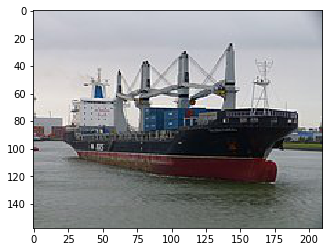

In [11]:
img_dir='../input/game-of-deep-learning-ship-datasets/train/images/'
image = plt.imread(img_dir+train_images[150])
print("Image shape =", image.shape)
train_input_shape = image.shape
plt.imshow(image)
plt.show()

In [12]:
n_classes = len(train_df.category.unique())
print("Number of unique classes =", n_classes)

Number of unique classes = 5


In [13]:
train_df['category']=train_df['category'].astype('str')

In [14]:
IMG_SIZE = 331
BATCH_SIZE = 16
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                              directory=img_dir,
                                              x_col="image",
                                              y_col="category",
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              seed=42,
                                              subset="training",
                                              class_mode="categorical",
                                             color_mode='rgb',
                                             shuffle=True)

valid_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                              directory=img_dir,
                                              x_col="image",
                                              y_col="category",
                                              target_size=(IMG_SIZE, IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              seed=42,
                                              subset="validation",
                                              class_mode="categorical",
                                             color_mode='rgb',
                                             shuffle=True)

Found 4689 images belonging to 5 classes.
Found 1563 images belonging to 5 classes.


In [15]:
def loss_accuracy_plot(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [16]:

def get_test_data():
    test_datagen=ImageDataGenerator(rescale=1./255.)
    test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=img_dir,
                                                x_col="image",
                                                y_col=None,
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                seed=42,
                                                shuffle=False,
                                                batch_size=1,
                                                class_mode=None)
    return test_generator

def get_train_data():
    data = ImageDataGenerator(rescale=1./255)
    data_generator = data.flow_from_dataframe(dataframe=train_df,
                                                directory=img_dir,
                                                x_col="image",
                                                y_col="category",
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                class_mode="categorical")
    return data_generator

In [17]:
def get_modelInceptionResNetV2(train_generator,valid_generator,epochs,IMG_SIZE):
    print('Running keras application for InceptionResNetV2')
    base_model = InceptionResNetV2(weights='../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    print('Model loaded')
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    dropout1 = Dropout(0.7)
    x = dropout1(x)
    preds=Dense(5,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)

    adam = tf.train.AdamOptimizer(learning_rate=0.0001)
    rmsProp=RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=rmsProp,loss='categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, 
                                verbose=1, mode='auto')
    check=ModelCheckpoint('.mdl_wts.inceptionResnetv2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    import time
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    start = time.time()
    history = model.fit_generator(
        train_generator,
          epochs=epochs,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
        callbacks=[reduce_lr,check,early_stop]
    )
    print("Time taken to train-test split: ", (time.time() - start)/60)
    print('plotting')
    loss_accuracy_plot(history)
    return model

def get_modelVGG(train_generator,valid_generator,epochs,IMG_SIZE):
    print('Running keras application for VGG')
    base_model = VGG16(weights='../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    print('Model loaded')
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    dropout1 = Dropout(0.7)
    x = dropout1(x)
    preds=Dense(5,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)

    adam = tf.train.AdamOptimizer(learning_rate=0.0001)
    rmsProp=RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=rmsProp,loss='categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, 
                                verbose=1, mode='auto')
    check=ModelCheckpoint('.mdl_wts.vgg.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    import time
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    start = time.time()
    history = model.fit_generator(
        train_generator,
          epochs=epochs,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
        callbacks=[reduce_lr,check,early_stop]
    )
    print("Time taken to train-test split: ", (time.time() - start)/60)
    print('plotting')
    loss_accuracy_plot(history)
    return model

def get_modelResnet50(train_generator,valid_generator,epochs,IMG_SIZE):
    print('Running keras application for Resnet50')
    base_model = ResNet50(weights='../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    print('Model loaded')
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    dropout1 = Dropout(0.7)
    x = dropout1(x)
    preds=Dense(5,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)

    adam = tf.train.AdamOptimizer(learning_rate=0.0001)
    rmsProp=RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=rmsProp,loss='categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, 
                                verbose=1, mode='auto')
    check=ModelCheckpoint('.mdl_wts.resnet50.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    import time
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    start = time.time()
    history = model.fit_generator(
        train_generator,
          epochs=epochs,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
        callbacks=[reduce_lr,check,early_stop]
    )
    print("Time taken to train-test split: ", (time.time() - start)/60)
    print('plotting')
    loss_accuracy_plot(history)
    return model

#great
def get_modelInceptionV3(train_generator,valid_generator,epochs,IMG_SIZE):
    print('Running keras application for InceptionV3')
    base_model = InceptionV3(weights='../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    print('Model loaded')
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    dropout1 = Dropout(0.7)
    x = dropout1(x)
    preds=Dense(5,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)
    adam = tf.train.AdamOptimizer(learning_rate=0.0001)
    rmsProp=RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=rmsProp,loss='categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, 
                                verbose=1, mode='auto')
    check=ModelCheckpoint('.mdl_wts.inceptionV3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    import time
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    start = time.time()
    history = model.fit_generator(
        train_generator,
          epochs=epochs,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID
        ,
        callbacks=[reduce_lr,check,early_stop]
    )
    print("Time taken to train-test split: ", (time.time() - start)/60)
    print('plotting')
    loss_accuracy_plot(history)
    return model

def get_modelXception(train_generator,valid_generator,epochs,IMG_SIZE):
    print('Running keras application for Xception')
    base_model = Xception(weights='../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    print('Model loaded')
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    dropout1 = Dropout(0.7)
    x = dropout1(x)
    preds=Dense(5,activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)
    adam = tf.train.AdamOptimizer(learning_rate=0.0001)
    rmsProp=RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=rmsProp,loss='categorical_crossentropy',metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, 
                                verbose=1, mode='auto')
    check=ModelCheckpoint('.mdl_wts.xception.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
    start = time.time()
    history = model.fit_generator(
        train_generator,
          epochs=epochs,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,
          validation_steps=STEP_SIZE_VALID,
        callbacks=[reduce_lr,check,early_stop]
    )
    print("Time taken to train-test split: ", (time.time() - start)/60)
    print('plotting')
    loss_accuracy_plot(history)
    return model



def predict_main(model,epochs):
    print('getting_train_test_generator')
    train_generator_main= get_train_data()
    test_generator_main=get_test_data()
    STEP_SIZE_TRAIN=test_generator_main.n//test_generator_main.batch_size
    start = time.time()
    history = model.fit_generator(
         train_generator_main,
          epochs=epochs,
          steps_per_epoch=STEP_SIZE_TRAIN
    )
    print("Time taken to train: ", (time.time() - start)/60)
    print('start predicting')
    predictions = model.predict_generator(test_generator_main, verbose=1)
    return predictions


def submission(pred,model):
    pred=np.argmax(pred,axis=1)
    results=pd.DataFrame({"image":test_df["image"],
                        "category":pred})
    results['category']=results['category'].apply(lambda x: x+1)
    print(results['category'].value_counts())
    results.to_csv('sub_generator_'+model+'.csv',index=False)
    print(results.head(10))
  
  
import time

Running keras application for Xception
Instructions for updating:
Colocations handled automatically by placer.
Model loaded
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
294/294 [==============================] - 170s 577ms/step - loss: 0.4471 - acc: 0.8447 - val_loss: 0.1960 - val_acc: 0.9424
Epoch 2/10
294/294 [==============================] - 151s 515ms/step - loss: 0.1112 - acc: 0.9676 - val_loss: 0.1597 - val_acc: 0.9539
Epoch 3/10
294/294 [==============================] - 151s 513ms/step - loss: 0.0438 - acc: 0.9876 - val_loss: 0.4256 - val_acc: 0.9219
Epoch 4/10
294/294 [==============================] - 151s 513ms/step - loss: 0.0463 - acc: 0.9898 - val_loss: 0.2253 - val_acc: 0.9527
Epoch 5/10
294/294 [==============================] - 151s 512ms/step - loss: 0.0330 - acc: 0.9927 - val_loss: 0.2510 - val_acc: 0.9520
Epoch 6/10
294/294 [=============

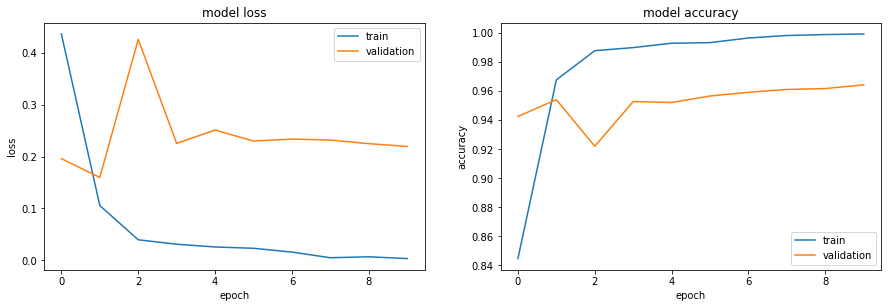

getting_train_test_generator
Found 6252 images belonging to 5 classes.
Found 2680 images.
Epoch 1/10
391/391 [==============================] - 188s 481ms/step - loss: 0.0668 - acc: 0.9794
Epoch 2/10
391/391 [==============================] - 187s 479ms/step - loss: 0.0177 - acc: 0.9936
Epoch 3/10
391/391 [==============================] - 188s 480ms/step - loss: 0.0115 - acc: 0.9960
Epoch 4/10
391/391 [==============================] - 188s 481ms/step - loss: 0.0065 - acc: 0.9978
Epoch 5/10
391/391 [==============================] - 189s 482ms/step - loss: 0.0073 - acc: 0.9986
Epoch 6/10
391/391 [==============================] - 189s 483ms/step - loss: 0.0037 - acc: 0.9990
Epoch 7/10
391/391 [==============================] - 189s 482ms/step - loss: 0.0027 - acc: 0.9992
Epoch 8/10
391/391 [==============================] - 189s 483ms/step - loss: 0.0021 - acc: 0.9992
Epoch 9/10
391/391 [==============================] - 189s 483ms/step - loss: 0.0020 - acc: 0.9995
Epoch 10/10
391/391

In [18]:
import time
xception_model=get_modelXception(train_generator,valid_generator,10,IMG_SIZE)
xception_model.load_weights(filepath = '.mdl_wts.xception.hdf5')
y_pred_xception=predict_main(xception_model,10)
submission(y_pred_xception,'xception_model_cb')

Running keras application for InceptionV3
Model loaded
Epoch 1/10
294/294 [==============================] - 157s 535ms/step - loss: 0.5062 - acc: 0.8211 - val_loss: 0.2889 - val_acc: 0.9168
Epoch 2/10
294/294 [==============================] - 76s 258ms/step - loss: 0.1987 - acc: 0.9356 - val_loss: 0.2819 - val_acc: 0.9399
Epoch 3/10
294/294 [==============================] - 76s 258ms/step - loss: 0.1242 - acc: 0.9623 - val_loss: 0.2618 - val_acc: 0.9539
Epoch 4/10
294/294 [==============================] - 75s 254ms/step - loss: 0.0992 - acc: 0.9721 - val_loss: 0.6067 - val_acc: 0.9060
Epoch 5/10
294/294 [==============================] - 75s 254ms/step - loss: 0.0756 - acc: 0.9802 - val_loss: 0.5232 - val_acc: 0.9341
Epoch 6/10
294/294 [==============================] - 75s 255ms/step - loss: 0.0815 - acc: 0.9804 - val_loss: 0.3974 - val_acc: 0.9424
Epoch 7/10
294/294 [==============================] - 75s 255ms/step - loss: 0.0581 - acc: 0.9853 - val_loss: 1.9781 - val_acc: 0.8042

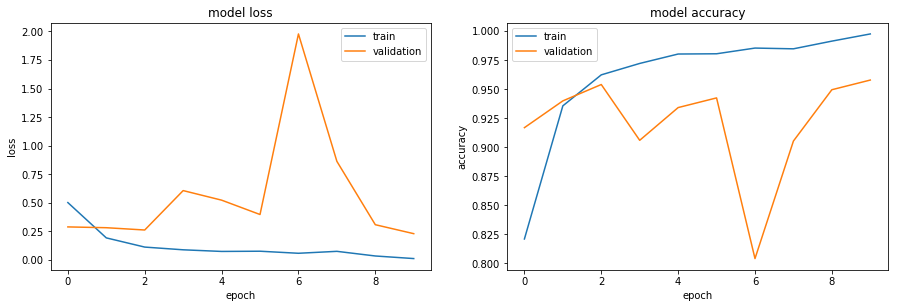

getting_train_test_generator
Found 6252 images belonging to 5 classes.
Found 2680 images.
Epoch 1/10
391/391 [==============================] - 90s 231ms/step - loss: 0.0752 - acc: 0.9834
Epoch 2/10
391/391 [==============================] - 89s 228ms/step - loss: 0.0254 - acc: 0.9942
Epoch 3/10
391/391 [==============================] - 89s 229ms/step - loss: 0.0104 - acc: 0.9968
Epoch 4/10
391/391 [==============================] - 89s 228ms/step - loss: 0.0121 - acc: 0.9982
Epoch 5/10
391/391 [==============================] - 89s 228ms/step - loss: 0.0062 - acc: 0.9987
Epoch 6/10
391/391 [==============================] - 89s 228ms/step - loss: 0.0035 - acc: 0.9984
Epoch 7/10
391/391 [==============================] - 89s 228ms/step - loss: 0.0055 - acc: 0.9989
Epoch 8/10
391/391 [==============================] - 89s 229ms/step - loss: 0.0052 - acc: 0.9990
Epoch 9/10
391/391 [==============================] - 90s 229ms/step - loss: 0.0037 - acc: 0.9987
Epoch 10/10
391/391 [=======

In [19]:

inceptionV3_model=get_modelInceptionV3(train_generator,valid_generator,10,IMG_SIZE)
inceptionV3_model.load_weights(filepath = '.mdl_wts.inceptionV3.hdf5')
y_pred_inceptionV3=predict_main(inceptionV3_model,10)
submission(y_pred_inceptionV3,'inceptionV3_model_cb')

In [20]:
import gc
gc.collect()
# inceptionV3_model=get_modelInceptionV3(train_generator,valid_generator,10,IMG_SIZE)
# y_pred_inceptionV3=predict_main(inceptionV3_model,10)
# submission(y_pred_inceptionV3,'inceptionV3_model1')

6081

In [21]:
import gc
gc.collect()
inception_resnet_model=get_modelInceptionResNetV2(train_generator,valid_generator,10,IMG_SIZE)
inception_resnet_model.load_weights(filepath = '.mdl_wts.inceptionResnetv2.hdf5')
y_pred_inception_resnet=predict_main(inception_resnet_model,10)
submission(y_pred_inception_resnet,'inception_resnet_model_cb')

Running keras application for InceptionResNetV2
Model loaded
Epoch 1/10
294/294 [==============================] - 667s 2s/step - loss: 0.4443 - acc: 0.8411 - val_loss: 0.4212 - val_acc: 0.9213
Epoch 2/10
294/294 [==============================] - 173s 587ms/step - loss: 0.1723 - acc: 0.9463 - val_loss: 0.2712 - val_acc: 0.9469
Epoch 3/10
294/294 [==============================] - 170s 577ms/step - loss: 0.0904 - acc: 0.9761 - val_loss: 0.2834 - val_acc: 0.9271
Epoch 4/10
294/294 [==============================] - 171s 581ms/step - loss: 0.0862 - acc: 0.9808 - val_loss: 0.2457 - val_acc: 0.9597
Epoch 5/10
294/294 [==============================] - 169s 573ms/step - loss: 0.0683 - acc: 0.9846 - val_loss: 0.5538 - val_acc: 0.9469
Epoch 6/10
294/294 [==============================] - 169s 574ms/step - loss: 0.0554 - acc: 0.9846 - val_loss: 0.5001 - val_acc: 0.9207
Epoch 7/10
294/294 [==============================] - 168s 572ms/step - loss: 0.0535 - acc: 0.9887 - val_loss: 0.3630 - val_ac

getting_train_test_generator
Found 6252 images belonging to 5 classes.
Found 2680 images.
Epoch 1/10
391/391 [==============================] - 203s 519ms/step - loss: 0.0612 - acc: 0.9862
Epoch 2/10
391/391 [==============================] - 206s 528ms/step - loss: 0.0122 - acc: 0.9962
Epoch 3/10
391/391 [==============================] - 207s 530ms/step - loss: 0.0063 - acc: 0.9978
Epoch 4/10
391/391 [==============================] - 207s 530ms/step - loss: 0.0058 - acc: 0.9989
Epoch 5/10
391/391 [==============================] - 208s 532ms/step - loss: 0.0048 - acc: 0.9987
Epoch 6/10
391/391 [==============================] - 208s 532ms/step - loss: 0.0029 - acc: 0.9994
Epoch 7/10
391/391 [==============================] - 207s 530ms/step - loss: 0.0035 - acc: 0.9995
Epoch 8/10
391/391 [==============================] - 207s 530ms/step - loss: 0.0034 - acc: 0.9994
Epoch 9/10
391/391 [==============================] - 208s 531ms/step - loss: 1.6612e-04 - acc: 1.0000
Epoch 10/10
391

In [22]:
y_pred_ens=(y_pred_xception*0.6+y_pred_inceptionV3*0.2+y_pred_inception_resnet*0.2)
y_pred_ens
submission(y_pred_ens,'ensemble_3_models_cb')

1    914
5    516
2    502
3    392
4    356
Name: category, dtype: int64
         image  category
0  1007700.jpg         4
1  1011369.jpg         4
2  1051155.jpg         4
3  1062001.jpg         2
4  1069397.jpg         4
5  1072861.jpg         4
6  1097264.jpg         4
7  1098763.jpg         2
8  1098766.jpg         2
9  1101145.jpg         4


In [23]:
y_pred_ens=(y_pred_xception*0.7+y_pred_inceptionV3*0.3)
y_pred_ens
submission(y_pred_ens,'ensemble_2_models_cb')

1    916
5    512
2    502
3    394
4    356
Name: category, dtype: int64
         image  category
0  1007700.jpg         4
1  1011369.jpg         4
2  1051155.jpg         4
3  1062001.jpg         2
4  1069397.jpg         4
5  1072861.jpg         4
6  1097264.jpg         4
7  1098763.jpg         2
8  1098766.jpg         2
9  1101145.jpg         4


In [24]:
# def get_modelNasNet(train_generator,valid_generator,epochs,IMG_SIZE):
#   print('Running keras application for VGG16')
#   base_model = VGG16(weights='imagenet', include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))
#   print('Model loaded')
#   x=base_model.output
#   x=GlobalAveragePooling2D()(x)
#   x = Flatten()(x)
#   x=Dense(1024,activation='relu')(x)
#   dropout1 = Dropout(0.5)
#   x = dropout1(x)
#   x=Dense(512,activation='relu')(x)
#   dropout2 = Dropout(0.5)
#   x = dropout2(x)
#   preds=Dense(5,activation='softmax')(x)
#   model=Model(inputs=base_model.input,outputs=preds)
#   adam = tf.train.AdamOptimizer(learning_rate=0.0001)
#   model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
#   early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
#                            mode='auto', restore_best_weights=True)
#   reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, 
#                                 verbose=1, mode='auto')
#   import time
#   STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#   STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#   start = time.time()
#   history = model.fit_generator(
#         train_generator,
#           epochs=epochs,
#           steps_per_epoch=STEP_SIZE_TRAIN,
#           validation_data=valid_generator,
#           validation_steps=STEP_SIZE_VALID,
#       callbacks=[early_stop]
#   )
#   print("Time taken to train-test split: ", (time.time() - start)/60)
#   print('plotting')
#   loss_accuracy_plot(history)
#   return model


# IMG_SIZE = 256
# BATCH_SIZE = 16
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25,
#                             rotation_range=40,
#                             width_shift_range=0.2,
#                             height_shift_range=0.2,
#                             shear_range=0.2,
#                             zoom_range=0.2,
#                             horizontal_flip=True,
#                             fill_mode='nearest')
# train_generator = datagen.flow_from_dataframe(dataframe=train_df,
#                                               directory=img_dir,
#                                               x_col="image",
#                                               y_col="category",
#                                               target_size=(IMG_SIZE, IMG_SIZE),
#                                               batch_size=BATCH_SIZE,
#                                               seed=42,
#                                               subset="training",
#                                               class_mode="categorical",
#                                              color_mode='rgb',
#                                              shuffle=True)

# valid_generator = datagen.flow_from_dataframe(dataframe=train_df,
#                                               directory=img_dir,
#                                               x_col="image",
#                                               y_col="category",
#                                               target_size=(IMG_SIZE, IMG_SIZE),
#                                               batch_size=BATCH_SIZE,
#                                               seed=42,
#                                               subset="validation",
#                                               class_mode="categorical",
#                                              color_mode='rgb',
#                                              shuffle=True)

In [25]:
# predictions1 = model.predict_generator(test_generator, verbose=1)
# predictions1

In [26]:


# model=get_modelInceptionV3()
# early_stop1 = EarlyStopping(monitor='acc', patience=20, verbose=1, 
#                            mode='auto', restore_best_weights=True)
# STEP_SIZE_TRAIN=data_generator.n//data_generator.batch_size
# start = time.time()

# history = model.fit_generator(
#         train_generator,
#         epochs=10,
#         steps_per_epoch=STEP_SIZE_TRAIN
#     ,
#     callbacks=[early_stop1]
# )
# print("Time taken to train: ", (time.time() - start)/60)

In [27]:
# predictions = model.predict_generator(test_generator, verbose=1)
# predictions


In [28]:
# subfile='gdrive/My Drive/AVDeeplearning/subs/sub_generator.csv'


In [29]:
# np.argmax(predictions,axis=1)

In [30]:
# results